
Training Xavier (Sigmoid) Model with Augmentation...
Epoch 1/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 63s 76ms/step - accuracy: 0.2556 - loss: 3.5550 - val_accuracy: 0.3024 - val_loss: 2.8132
Epoch 2/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 61s 78ms/step - accuracy: 0.3263 - loss: 2.6089 - val_accuracy: 0.3545 - val_loss: 2.2655
Epoch 3/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 59s 75ms/step - accuracy: 0.3514 - loss: 2.2420 - val_accuracy: 0.3267 - val_loss: 2.2728
Epoch 4/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 62s 79ms/step - accuracy: 0.3688 - loss: 2.0755 - val_accuracy: 0.3610 - val_loss: 2.0895
Epoch 5/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 59s 76ms/step - accuracy: 0.3749 - loss: 1.9889 - val_accuracy: 0.3578 - val_loss: 2.0381
Epoch 6/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 62s 79ms/step - accuracy: 0.3871 - loss: 1.9293 - val_accuracy: 0.3367 - val_loss: 2.0514
Epoch 7/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 60s 76ms/step - accuracy: 0.3843 - loss: 1.9004 - val_accuracy: 0.3243 - val_loss: 2.0960
Epoch 8/50
782/782 ━━━━━━━━━━━━━━━━━

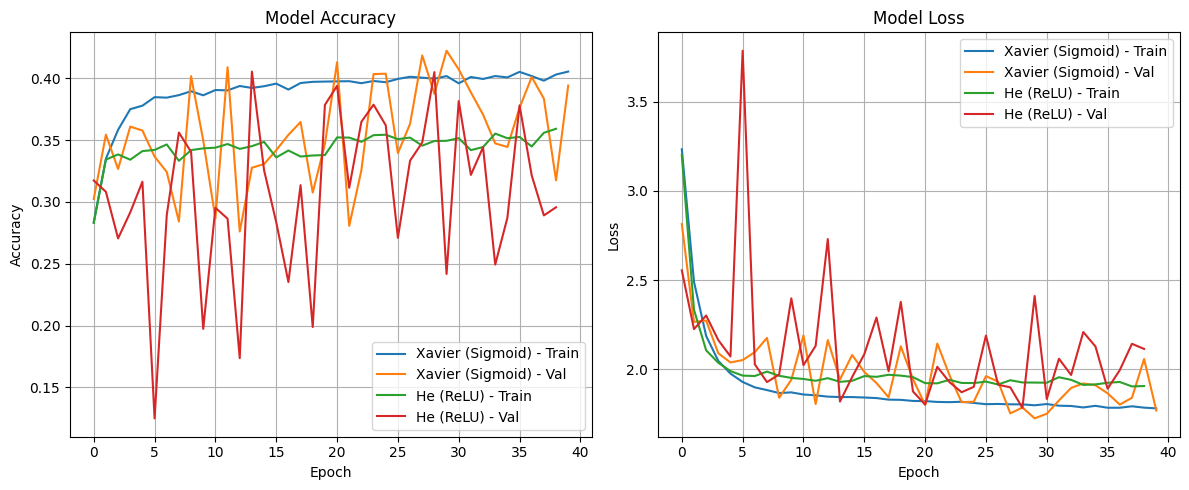

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, initializers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# -------------------------------
# 1. Load and preprocess CIFAR-10
# -------------------------------
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# -------------------------------
# 2. ImageDataGenerator for augmentation
# -------------------------------
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(x_train)

# -------------------------------
# 3. Function to create a model
# -------------------------------
def create_model(initializer, activation='relu', dropout_rate=0.0, regularize=None):
    model = models.Sequential([
        layers.Flatten(input_shape=(32, 32, 3)),
        layers.Dense(512, kernel_initializer=initializer, kernel_regularizer=regularize, activation=activation),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate),
        layers.Dense(256, kernel_initializer=initializer, kernel_regularizer=regularize, activation=activation),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate),
        layers.Dense(128, kernel_initializer=initializer, kernel_regularizer=regularize, activation=activation),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate),
        layers.Dense(10, activation='softmax')
    ])
    return model

# -------------------------------
# 4. Define initializers
# -------------------------------
xavier_initializer = initializers.GlorotNormal()
he_initializer = initializers.HeNormal()

# -------------------------------
# 5. Create models
# -------------------------------
xavier_model = create_model(
    initializer=xavier_initializer,
    activation='sigmoid',  # Xavier with Sigmoid
    dropout_rate=0.3,
    regularize=regularizers.L2(0.001)
)

he_model = create_model(
    initializer=he_initializer,
    activation='relu',  # He with ReLU
    dropout_rate=0.3,
    regularize=regularizers.L2(0.001)
)

# -------------------------------
# 6. Compile models (tuned LR)
# -------------------------------
xavier_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                     loss='categorical_crossentropy', metrics=['accuracy'])

he_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                 loss='categorical_crossentropy', metrics=['accuracy'])

# -------------------------------
# 7. Train models with EarlyStopping + Augmentation
# -------------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

print("\nTraining Xavier (Sigmoid) Model with Augmentation...")
history_xavier = xavier_model.fit(
    datagen.flow(x_train, y_train, batch_size=64),
    epochs=50,
    validation_data=(x_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

print("\nTraining He (ReLU) Model with Augmentation...")
history_he = he_model.fit(
    datagen.flow(x_train, y_train, batch_size=64),
    epochs=50,
    validation_data=(x_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

# -------------------------------
# 8. Evaluate
# -------------------------------
xavier_acc = xavier_model.evaluate(x_test, y_test, verbose=0)[1]
he_acc = he_model.evaluate(x_test, y_test, verbose=0)[1]
print("\nFinal Test Accuracy (Xavier - Sigmoid):", xavier_acc)
print("Final Test Accuracy (He - ReLU):", he_acc)

# -------------------------------
# 9. Plot Accuracy & Loss
# -------------------------------
plt.figure(figsize=(12,5))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(history_xavier.history['accuracy'], label='Xavier (Sigmoid) - Train')
plt.plot(history_xavier.history['val_accuracy'], label='Xavier (Sigmoid) - Val')
plt.plot(history_he.history['accuracy'], label='He (ReLU) - Train')
plt.plot(history_he.history['val_accuracy'], label='He (ReLU) - Val')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1,2,2)
plt.plot(history_xavier.history['loss'], label='Xavier (Sigmoid) - Train')
plt.plot(history_xavier.history['val_loss'], label='Xavier (Sigmoid) - Val')
plt.plot(history_he.history['loss'], label='He (ReLU) - Train')
plt.plot(history_he.history['val_loss'], label='He (ReLU) - Val')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
